# Imports

In [1]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, pandas as pd, sympy as sy, mpmath
from scipy import optimize
from astropy import units as u

In [2]:
mpmath.mp.dps = 25
print(mpmath.mp)

Mpmath settings:
  mp.prec = 86                [default: 53]
  mp.dps = 25                 [default: 15]
  mp.trap_complex = False     [default: False]


# Question 1

Create a Universal Variable Two Body Propogator

In [3]:
def C(z):

    return_val = None

    if z > 0:
        z = float(z)

        return_val = ( 1 - np.cos( np.sqrt(z) ) ) / z

    elif z < 0:
        z_sym = sy.symbols("z_sym")
        f = ( sy.cosh( sy.sqrt(-z_sym) )-1 ) / ( -z_sym )

        return_val = float( f.subs(z_sym, z).evalf() )

    else:
        return_val = 1/2

    return return_val
    
def S(z):

    return_val = None

    if z > 0:
        z = float(z)

        return_val = ( np.sqrt(z) - np.sin(np.sqrt(z)) ) / np.sqrt(z)**3

    elif z<0:
        z_sym = sy.symbols("z_sym")
        f = ( sy.sinh(sy.sqrt(-z_sym)) - sy.sqrt(-z_sym) ) / sy.sqrt(-z_sym)**3

        return_val = float(f.subs(z_sym, z).evalf())

    else:
        return_val = 1/6

    return return_val

In [4]:
def kepler(chi: float, mu: float, r_0_mag: float, v_r_0: float, alpha: float, delta_t: float) -> float:
    z = alpha*chi**2
    return (r_0_mag * v_r_0)/np.sqrt(mu) * chi**2 * C(z) + (1-alpha*r_0_mag)*chi**3 * S(z) + r_0_mag * chi - np.sqrt(mu)*delta_t

def kepler_prime(chi: float, mu: float, r_0_mag: float, v_r_0: float, alpha: float) -> float:
    z = alpha*chi**2
    return (r_0_mag * v_r_0)/np.sqrt(mu) * chi * ( 1 - alpha*chi**2 * S(z) ) + (1 - alpha*r_0_mag)*chi**2*C(z) + r_0_mag

def solve_kepler(mu: float, r_0_mag: float, v_r_0: float, alpha: float, delta_t: float, chi_0: float = None, tol = 1e-8, max_iter = 100):

    # if not provided, creating an initial guess for chi
    if not chi_0:
        chi_0 = np.sqrt(mu)*np.abs(alpha)*(delta_t)
    # creating f / fprime
    ratio_i =  kepler(chi_0, mu, r_0_mag, v_r_0, alpha, delta_t) / kepler_prime(chi_0, mu, r_0_mag, v_r_0, alpha)
    
    # starting iterations for newtons method
    chi_i = chi_0
    iter = 0
    while np.abs(ratio_i) > tol and iter <= max_iter:
        chi_i -= ratio_i
        ratio_i =  kepler(chi_i, mu, r_0_mag, v_r_0, alpha, delta_t) / kepler_prime(chi_i, mu, r_0_mag, v_r_0, alpha)
        iter += 1
    
    return chi_i

In [5]:
# deriving state vector for a given delta t
def propogate_orbit(r_0, v_0, delta_t, mu):

    # f and g functions
    def f(chi: float, alpha: float, r_0_mag: float): return 1 - (chi**2 / r_0_mag) * C(alpha*chi**2)

    def g(chi: float, alpha: float, delta_t: float, mu: float): return delta_t - 1/np.sqrt(mu) * chi**3 * S(alpha*chi**2)

    def f_dot(mu: float, r_0_mag: float, r_mag: float, alpha: float, chi: float):
        return np.sqrt(mu)/(r_mag*r_0_mag)*( alpha*chi**3 * S(alpha*chi**2) - chi)

    def g_dot(chi: float, alpha: float, r_mag: float):
        return 1 - chi**2 / r_mag * C(alpha*chi**2)
    
    r_0_mag = np.linalg.norm(r_0)
    v_0_mag = np.linalg.norm(v_0)

    v_r_0 = np.dot(r_0, v_0) / r_0_mag

    alpha = 2/r_0_mag - v_0_mag**2 / mu

    chi = solve_kepler(mu = mu, r_0_mag = r_0_mag, v_r_0 = v_r_0, alpha = alpha, delta_t = delta_t)
    r = f(chi = chi, alpha = alpha, r_0_mag = r_0_mag)*r_0 + g(chi = chi, alpha = alpha, delta_t = delta_t, mu = mu)*v_0
    r_mag = np.linalg.norm(r)

    v = f_dot(mu = mu, r_0_mag = r_0_mag, r_mag = r_mag, alpha = alpha, chi = chi)*r_0 + g_dot(chi = chi, alpha = alpha, r_mag = r_mag)*v_0

    return r, v


# Question 2

In [6]:
def lambert_solver(r_1, r_2, delta_t, mu, z_0 = 0.0, prograde = True, tol = 1e-8, max_iter = 100):
     r_1_mag = np.linalg.norm(r_1)
     r_2_mag = np.linalg.norm(r_2)

     # calculating angle between 
     delta_theta = np.arccos(np.dot(r_1, r_2)/(r_1_mag*r_2_mag))
     r_1_cross_r_2 = np.cross(r_1, r_2)
  
     # determining delta_theta based on orbit direction
     if prograde and (r_1_cross_r_2[-1]) < 0.0:
          delta_theta =  2*np.pi - delta_theta

     if not prograde and (r_1_cross_r_2[-1] >= 0.0):
               delta_theta = 2*np.pi - delta_theta
  
     # Calculating A
     A = np.sin(delta_theta) * np.sqrt( (r_1_mag*r_2_mag)/(1 - np.cos(delta_theta)) )
   
     # Definign y function
     def y(z):
          return r_1_mag + r_2_mag + A*(z*S(z) - 1)/(np.sqrt(C(z)))

     # defining F and F prime
     def F(z): return ( y(z) / C(z) )**(3/2) * (S(z)) + (A*np.sqrt(y(z))) - (np.sqrt(mu)*delta_t)
 
     def F_prime(z):
          if z == 0:
               y_0 = y(0)
               return np.sqrt(2)/40 * y_0**(3/2) + A/8*( np.sqrt(y_0) + A*np.sqrt( 1/(2*y_0) ) )
          else:
               y_z = y(z)
               C_z = C(z)
               S_z = S(z)
               return (y_z/C_z)**(3/2) * ( 1/(2*z)*(C_z - (3*S_z)/(2*C_z))  + (3 * S_z**2)/(4 * C_z) ) + (A/8 * ( 3*S_z/C_z*np.sqrt(y_z) + A*np.sqrt(C_z/y_z) ))

     # starting newton's method to find z
     z_i = z_0
     
     F_over_Fprime = F(z_i)/F_prime(z_i)

     iter = 0
     while np.abs(F_over_Fprime) > tol and iter <= max_iter:
     
          z_i = z_i - F_over_Fprime
          F_over_Fprime = F(z_i)/F_prime(z_i)
          iter += 1

     y_z = y(z_i)
     C_z = C(z_i)
     S_z = S(z_i)

     def f(z): return 1 - y_z/r_1_mag
     def g(z): return A*np.sqrt(y_z/mu)
     def f_dot(z): return np.sqrt(mu)/(r_1_mag*r_2_mag) * np.sqrt(y_z/C_z)*(z_i*S_z - 1)
     def g_dot(z): return 1 - y_z/r_2_mag

     v_1 = 1/g(z_i) * (r_2 - f(z_i)*r_1)
     v_2 = 1/g(z_i) * (g_dot(z_i)*r_2 - r_1)
     
     return v_1, v_2

In [7]:
lambert_solver(
                r_1 = np.array([5644, 2830, 4170]), 
                r_2 = np.array([-2240, 7320, 4980]), 
                delta_t = 1200,
                z_0 = 0.0, 
                mu = 3.986004418e5,
                tol = 1e-8,
                prograde = True,
                max_iter =  4
                )

(array([-4.88638468,  6.0225738 ,  3.04794707]),
 array([-6.91678659,  1.25491188, -1.39876795]))

# Question 3

## Maximum Velocity Values

In [8]:
max_delta_v_rendezvous =  50 # km/s
max_delta_v_flyby = 20 # km/s   

## Generating dates

In [9]:
first_launch_date = pd.Timestamp( year = 2017, month = 1, day = 1, hour = 0, minute = 0, second = 0 ).to_julian_date()
final_launch_date = pd.Timestamp( year = 2017, month = 12, day = 31, hour = 0, minute = 0, second = 0 ).to_julian_date()
launch_window = np.arange(start = first_launch_date, stop = final_launch_date + 1, step = 1)

first_arrival_date = pd.Timestamp( year = 2017, month = 8, day = 1, hour = 0, minute = 0, second = 0 ).to_julian_date()
final_arrival_date = pd.Timestamp( year = 2019, month = 1, day = 31, hour = 0, minute = 0, second = 0 ).to_julian_date()
arrival_window = np.arange(start = first_arrival_date, stop = final_arrival_date + 1, step = 1)

launch_ax, arrival_ax = np.meshgrid(launch_window, arrival_window)

## Given state vectors at JD = 2457754.5

In [10]:
r1I = np.array([3.515868886595499e-2, -3.162046390773074, 4.493983111703389])
r1I = (r1I*u.AU).to(u.km).value
v1I = np.array([-2.317577766980901e-3, 9.843360903693031e-3, -1.541856855538041e-2])
v1I = (v1I*u.AU/u.day).to(u.km/u.s).value

r2I = np.array([7.249472033259724, 14.61063037906177, 14.24274452216359])
r2I = (r2I*u.AU).to(u.km).value
v2I = np.array([-8.241709369476881e-3, -1.156219024581502e-2, -1.317135977481448e-2])
v2I = (v2I*u.AU/u.day).to(u.km/u.s).value


rE = np.array([1.796136509111975e-1, 9.667949206859814e-1, -3.668681017942158e-5])
rE = (rE*u.AU).to(u.km).value
vE = np.array([-1.720038360888334e-2, -3.211186197806460e-3, 7.927736735960840e-7])
vE = (vE*u.AU/u.day).to(u.km/u.s).value

## Earth Trajectory on Launch Window

In [11]:
r_E, v_E = [], []

for delta_t in launch_window-first_launch_date:
    r, v = propogate_orbit(
    rE, vE, delta_t*24*3600, 1.327e11
    )
    r_E.append(r)
    v_E.append(v)

## 1I/’Oumouamoua Trajectory on Arrival Window

In [12]:
r_1I, v_1I = [], []

for delta_t in arrival_window-first_launch_date:
    r, v = propogate_orbit(
    r1I, v1I, delta_t*24*3600, 1.327e11
    )
    r_1I.append(r)
    v_1I.append(v)

## Creating Porkchop Plots

In [13]:
delta_v_data_I1_flyby = np.empty((len(launch_window), len(arrival_window))).T
delta_v_data_I1_rv = np.empty((len(launch_window), len(arrival_window))).T

In [ ]:
error_count = 0
for i in range(len(launch_window)):
    print(i)
    earth_pos = r_E[i]
    earth_vel = v_E[i]
    for j in range(len(arrival_window)):
        I_pos = r_1I[j]
        I_vel = v_1I[j]

        delta_v = None
        if arrival_window[j] <= launch_window[i]:
            delta_v_data_I1_flyby[i][i] = delta_v
            delta_v_data_I1_rv[j][i] = delta_v
            continue
        else:
            delta_t = arrival_window[j] - launch_window[i]
            try:
                v_E_prograde, v_I_prograde = lambert_solver(earth_pos, I_pos, delta_t*24*3600, 1.327e11, prograde = True)
                v_E_retrograde, v_I_retrograde = lambert_solver(earth_pos, I_pos, delta_t*24*3600, 1.327e11, prograde = False)
            except: 
                error_count += 1
                print(f"Error Counter: {error_count}")
            delta_v_prograde = np.linalg.norm(v_E_prograde - earth_vel) + np.linalg.norm(v_I_prograde - I_vel)
            delta_v_retrograde = np.linalg.norm(v_E_retrograde - earth_vel) + np.linalg.norm(v_I_retrograde - I_vel)
            
            if abs(delta_v_prograde) < abs(delta_v_retrograde):
                delta_v = delta_v_prograde
            else:
                delta_v = delta_v_retrograde
                
            if delta_v < max_delta_v_flyby:
                delta_v_data_I1_flyby[j][i] = delta_v
            else: 
                delta_v_data_I1_flyby[j][i] = None
                
            if delta_v < max_delta_v_rendezvous:
                delta_v_data_I1_rv[j][i] = delta_v
            else: 
                delta_v_data_I1_rv[j][i] = None

In [14]:
df = pd.DataFrame(delta_v_data_I1_rv, index = pd.to_datetime(arrival_window, unit = "D", origin = "julian").strftime('%m/%d/%Y'), columns = pd.to_datetime(launch_window, unit = "D", origin = "julian").strftime('%m/%d/%Y'))

(Text(0.5, 69.0, 'Launch Date'),
 Text(69.0, 0.5, 'Arrival Date'),
 Text(0.5, 1.0, 'Oumouamoua Rendezvous'))

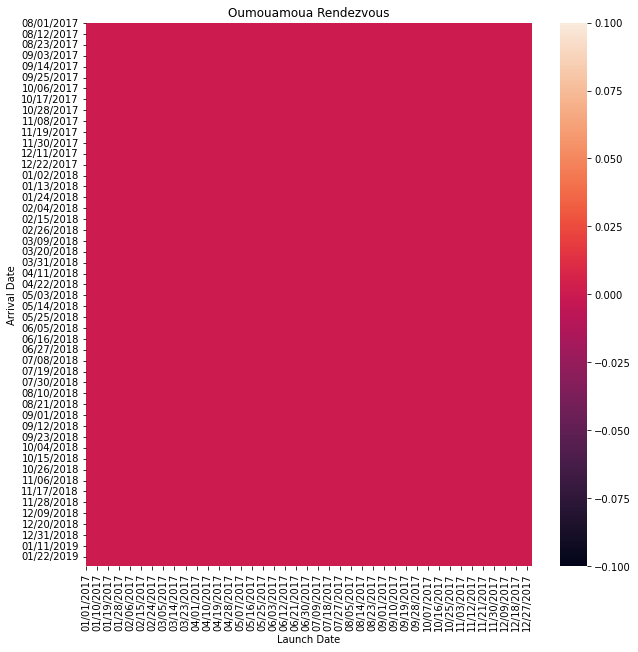

In [15]:
fig = plt.figure(figsize = (10, 10))
ax = sns.heatmap(df)
ax.set_xlabel("Launch Date"), ax.set_ylabel("Arrival Date"), ax.set_title("Oumouamoua Rendezvous")

In [16]:
df = pd.DataFrame(delta_v_data_I1_flyby, index = pd.to_datetime(arrival_window, unit = "D", origin = "julian").strftime('%m/%d/%Y'), columns = pd.to_datetime(launch_window, unit = "D", origin = "julian").strftime('%m/%d/%Y'))

(Text(0.5, 69.0, 'Launch Date'),
 Text(69.0, 0.5, 'Arrival Date'),
 Text(0.5, 1.0, 'Oumouamoua Flyby'))

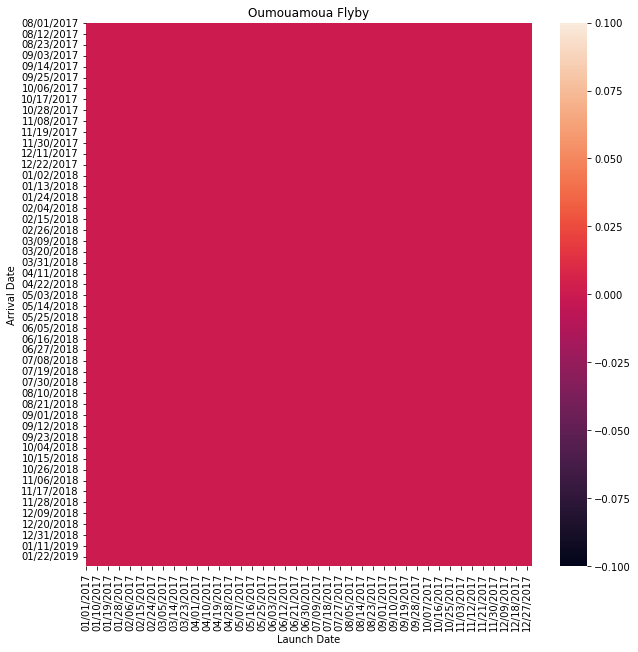

In [17]:
fig = plt.figure(figsize = (10, 10))
ax = sns.heatmap(df)
ax.set_xlabel("Launch Date"), ax.set_ylabel("Arrival Date"), ax.set_title("Oumouamoua Flyby")

# Question 4

Disclaimer: I apologize, but I have no plots for this question. I've tested my numerical solver for Lambert's problem and Kepler's equation with the example provided in the course slack, and received correct answers. However, when I try to call the solver for Lambert's problem, overflow and double scalar errors are raised almost immediatly. Even when throwing exceptions, the code just seems to run indefinitely without any output. I'm not sure if this was a limitation of a function call, or a limitation on the capacity of my rather dated computer. Either way, it frequently caused issues with the Jupyter Notebook Kernel, necessitating restarts.

## Generating Dates

In [18]:
first_launch_date = pd.Timestamp( year = 2017, month = 1, day = 1, hour = 0, minute = 0, second = 0 ).to_julian_date()
final_launch_date = pd.Timestamp( year = 2017, month = 7, day = 31, hour = 0, minute = 0, second = 0 ).to_julian_date()
launch_window = np.arange(start = first_launch_date, stop = final_launch_date + 1, step = 1)

first_arrival_date = pd.Timestamp( year = 2019, month = 6, day = 1, hour = 0, minute = 0, second = 0 ).to_julian_date()
final_arrival_date = pd.Timestamp( year = 2022, month = 1, day = 31, hour = 0, minute = 0, second = 0 ).to_julian_date()
arrival_window = np.arange(start = first_arrival_date, stop = final_arrival_date + 1, step = 1)

launch_ax, arrival_ax = np.meshgrid(launch_window, arrival_window)

## Maximum Velocity Values

In [19]:
max_delta_v_flyby = 20
max_delta_v_rendezvous = 60

## Comet 2I/Borisov Trajectory on Arrival Window

Disclaimer: I apologize, but I have no plots for this question. I've tested my numerical solver for Lambert's problem and Kepler's equation with the example provided in the course slack, and received correct answers. However, when I try to call the solver for Lambert's problem, overflow and double scalar errors are raised almost immediatly. Even when throwing exceptions, the code just seems to run indefinitely without any output. I'm not sure if this was a limitation of a function call, or a limitation on the capacity of my rather dated computer. Either way, it frequently caused issues with the Jupyter Notebook Kernel, necessitating restarts.

In [20]:
r_2I, v_2I = [], []

for delta_t in arrival_window-first_launch_date:
    r, v = propogate_orbit(
    r2I, v2I, delta_t*24*3600, 1.327e11
    )
    r_2I.append(r)
    v_2I.append(v)

## Creating Porkchop Plots

In [23]:
delta_v_data_2I_flyby = np.empty((len(launch_window), len(arrival_window))).T
delta_v_data_2I_rv = np.empty((len(launch_window), len(arrival_window))).T

In [ ]:
error_count = 0
for i in range(len(launch_window)):
    print(i)
    earth_pos = r_E[i]
    earth_vel = v_E[i]
    for j in range(len(arrival_window)):
        I_pos = r_2I[j]
        I_vel = v_2I[j]

        delta_v = None
        if arrival_window[j] <= launch_window[i]:
            delta_v_data_2I_flyby[j][i] = delta_v
            delta_v_data_2I_rv[j][i] = delta_v
            continue
        else:
            delta_t = arrival_window[j] - launch_window[i]
            try:
                v_E_prograde, v_I_prograde = lambert_solver(earth_pos, I_pos, delta_t*24*3600, 1.327e11, prograde = True)
                v_E_retrograde, v_I_retrograde = lambert_solver(earth_pos, I_pos, delta_t*24*3600, 1.327e11, prograde = False)
            except: 
                error_count += 1
                print(f"Error Counter: {error_count}")
            delta_v_prograde = np.linalg.norm(v_E_prograde - earth_vel) + np.linalg.norm(v_I_prograde - I_vel)
            delta_v_retrograde = np.linalg.norm(v_E_retrograde - earth_vel) + np.linalg.norm(v_I_retrograde - I_vel)
            
            if abs(delta_v_prograde) < abs(delta_v_retrograde):
                delta_v = delta_v_prograde
            else:
                delta_v = delta_v_retrograde
                
            if delta_v < max_delta_v_flyby:
                delta_v_data_2I_flyby[j][i] = delta_v
            else: 
                delta_v_data_2I_flyby[j][i] = None
                
            if delta_v < max_delta_v_rendezvous:
                delta_v_data_2I_rv[j][i] = delta_v
            else: 
                delta_v_data_2I_rv[j][i] = None

In [24]:
df = pd.DataFrame(delta_v_data_2I_rv, index = pd.to_datetime(arrival_window, unit = "D", origin = "julian").strftime('%m/%d/%Y'), columns = pd.to_datetime(launch_window, unit = "D", origin = "julian").strftime('%m/%d/%Y'))

(Text(0.5, 69.0, 'Launch Date'),
 Text(69.0, 0.5, 'Arrival Date'),
 Text(0.5, 1.0, '2I/Borisov Rendezvous'))

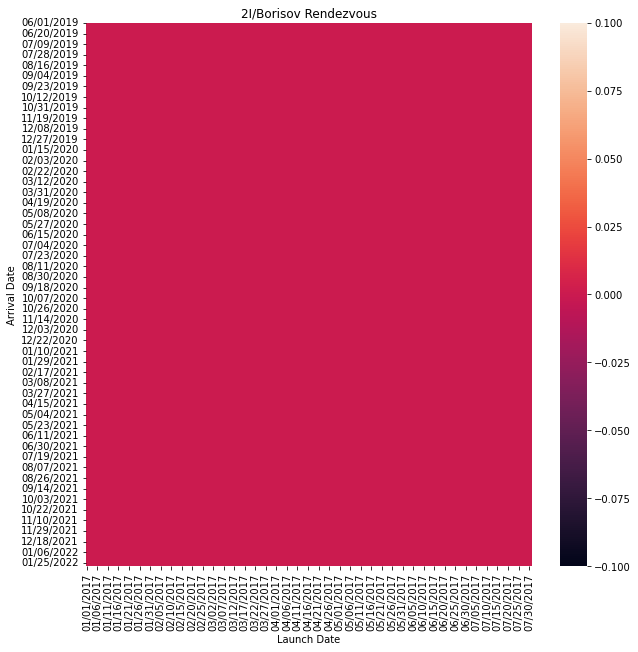

In [25]:
fig = plt.figure(figsize = (10, 10))
ax = sns.heatmap(df)
ax.set_xlabel("Launch Date"), ax.set_ylabel("Arrival Date"), ax.set_title("2I/Borisov Rendezvous")

In [26]:
df = pd.DataFrame(delta_v_data_2I_flyby, index = pd.to_datetime(arrival_window, unit = "D", origin = "julian").strftime('%m/%d/%Y'), columns = pd.to_datetime(launch_window, unit = "D", origin = "julian").strftime('%m/%d/%Y'))

(Text(0.5, 69.0, 'Launch Date'),
 Text(69.0, 0.5, 'Arrival Date'),
 Text(0.5, 1.0, '2I/Borisov Flyby'))

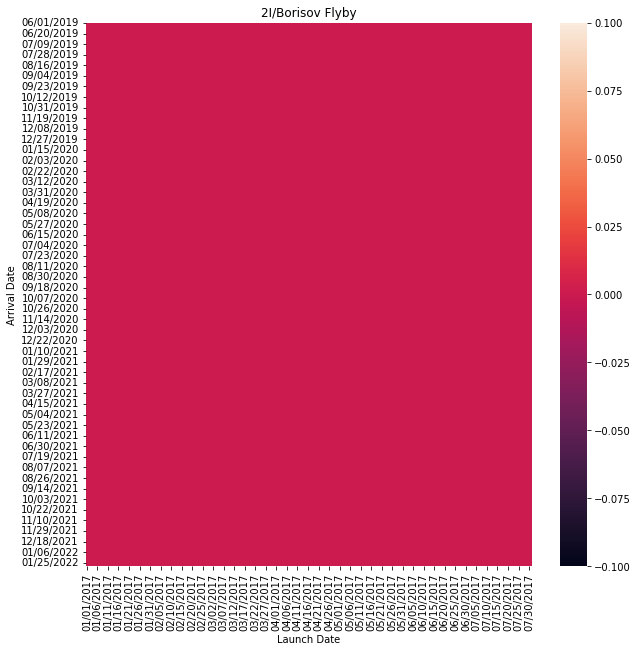

In [27]:
fig = plt.figure(figsize = (10, 10))
ax = sns.heatmap(df)
ax.set_xlabel("Launch Date"), ax.set_ylabel("Arrival Date"), ax.set_title("2I/Borisov Flyby")

# Question 5

Initial State Vectors to Orbital Elements

In [52]:
def state2elem(r, v, mu):
    mu_E = 398600
    def a(r, v, mu = mu_E): return (2/np.linalg.norm(r) - np.linalg.norm(v)**2/mu)**-1
    
    def h(r, v): return np.cross(r,v)

    def e(r, v, mu = mu_E): return 1/mu*np.cross(v, h(r, v)) - r/np.linalg.norm(r)

    def inclination(r, v):
        h_vec = h(r, v)
        return np.arccos( np.dot(h_vec, np.array([0, 0, 1]))/np.linalg.norm(h_vec) )

    def nodes(r, v):
        return np.cross( np.array([0, 0, 1]), h(r, v) )

    def raan(r, v):
        n = nodes(r, v)
        return np.arccos( np.dot( n, np.array([1, 0, 0]) ) / np.linalg.norm(n) )

    def argument_of_periapsis(r, v, mu = mu_E):
        n = nodes(r, v)
        return np.arccos( np.dot(n, e(r, v)) / ( np.linalg.norm(n)*np.linalg.norm(e(r, v)) ) )

    def f(r, v, mu = mu_E): 
        h_mag = np.linalg.norm(h(r, v))
        e_mag = np.linalg.norm(e(r, v, mu))
        r_mag = np.linalg.norm(r)
        nu = np.arccos( 1/e_mag * (h_mag**2 / (mu*r_mag) - 1) )
        
        if np.dot(r, v) < 0:
            nu = 2*np.pi - nu
        return nu
    
    return a(r, v, mu), np.linalg.norm(e(r, v, mu)), inclination(r, v), raan(r, v), argument_of_periapsis(r, v, mu), f(r, v, mu)

An object is interstellar when it's orbit is not bound by the sun. This occurs when the specific orbital energy of the body is greater than zero:
\begin{gather*}
\varepsilon = \frac{v^2}{2} - \frac{\mu}{2r} = -\frac{\mu}{2a}
\end{gather*}
As can be seen from the equation above, unbounded orbits occur when either $a < 0$ (hyperbolic trajectory) or $\frac{1}{a} = 0$ (parabolic trajectory ). If a body has a semimajor axis that satisfies this condition with respect to the Sun, it is most likely an interstellar object. This is also shown by an eccentricity $e \geq 1$. Supporting, but not definite, evidince of interstellar origin is extreme inclinations. Some stellar objects such as bodies in the Kuiper Belt and Oort Cloud bodies can have higher inclinations as well, but stellar objects exhibit a trend of low inclinations.

## Orbital Elements of Oumouamoua

In [53]:
a, e, i, raan, w, f = state2elem(r1I, v1I, 1.327e11)

print(f"Orbital Parameters of Oumouamoua at JD = 2457754.5 \n--------------------------------------------------")
print(f"Semimajor Axis: a = {a:0.5f} km = {(a*u.km).to(u.AU).value:0.5f} AU")
print(f"Eccentricity: e = {e:0.5f}")
print(f"Incination: i = {i:0.5f} rad = {np.rad2deg(i):0.5f} deg")
print(f"Right Ascension (Longitude) of Ascending Node: \u03A9 = {raan:0.5f} rad = {np.rad2deg(raan):0.5f} deg")
print(f"Argument of Periapsis: \u03C9 = {w:05f} rad = {np.rad2deg(w):0.5f} deg")
print(f"True Anomaly: f = {f:0.5f} rad = {np.rad2deg(f):0.5f} deg")


Orbital Parameters of Oumouamoua at JD = 2457754.5 
--------------------------------------------------
Semimajor Axis: a = -190542036.17926 km = -1.27369 AU
Eccentricity: e = 1.20091
Incination: i = 2.14228 rad = 122.74333 deg
Right Ascension (Longitude) of Ascending Node: Ω = 0.42919 rad = 24.59085 deg
Argument of Periapsis: ω = 3.033521 rad = 173.80792 deg
True Anomaly: f = 3.86831 rad = 221.63812 deg


Since the semimajor axis is negative, the orbital energy of Oumouamoua will be positive, meaning the orbit is not bounded by the Sun. The orbit will also be hyperbolic, as seen by the eccentricity being above 1, meaning it is on a Sun escape trajectory. Both of these point to the fact that Oumouamoua is an interstellar object.

## Orbital Elements of 2I/Borisov

In [54]:
a, e, i, raan, w, f = state2elem(r2I, v2I, 1.327e11)

print(f"Orbital Parameters of 2I/Borisov at JD = 2457754.5 \n--------------------------------------------------")
print(f"Semimajor Axis: a = {a:0.5f} km = {(a*u.km).to(u.AU).value:0.5f} AU")
print(f"Eccentricity: e = {e:0.5f}")
print(f"Incination: i = {i:0.5f} rad = {np.rad2deg(i):0.5f} deg")
print(f"Right Ascension (Longitude) of Ascending Node: \u03A9 = {raan:0.5f} rad = {np.rad2deg(raan):0.5f} deg")
print(f"Argument of Periapsis: \u03C9 = {w:05f} rad = {np.rad2deg(w):0.5f} deg")
print(f"True Anomaly: f = {f:0.5f} rad = {np.rad2deg(f):0.5f} deg")

Orbital Parameters of 2I/Borisov at JD = 2457754.5 
--------------------------------------------------
Semimajor Axis: a = -127280116.02089 km = -0.85082 AU
Eccentricity: e = 3.35967
Incination: i = 0.76823 rad = 44.01660 deg
Right Ascension (Longitude) of Ascending Node: Ω = 0.90296 rad = 51.73555 deg
Argument of Periapsis: ω = 2.934925 rad = 168.15883 deg
True Anomaly: f = 4.53411 rad = 259.78537 deg


Since the semimajor axis is negative, the orbital energy of 2I/Borisov will be positive, meaning the orbit is not bounded by the Sun. The orbit will also be hyperbolic, as seen by the eccentricity being above 1, meaning it is on a Sun escape trajectory. Both of these point to the fact that 2I/Borisov is an interstellar object.

# Question 6

A flyby to Oumouamoua is either impossible or impractical on a simple transfer orbit due to the relatively small $\Delta$ V required. A rendezvous with Oumouamoua would probably be much easier. The same can be said for a flyby and rendezvous with 2I/Borisov. Since I was unable to obtain plots for the necessary $\Delta$ V to rendezvous or flyby either object, I can't pick one.